In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

device = torch.device('cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

In [11]:
def true_1D_1(x): #True function for 1D_1 dy2/dx2 + dy/dx - 6y = 0; BC1: y(0)=2; BC2: dy/dx at (x=0) = -1; x \in [0,2]
    y = np.exp(2*x) + np.exp(-3*x)
    return y

In [12]:
x = np.linspace(0,2,100).reshape(-1,1)
ysol = true_1D_1(x)

bc1_x = np.array(0)
bc1_y = np.array(0)
 
x_test = x.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().to(device)

y_true = true_1D_1(x_test)

# Domain bounds
lb = np.array(x[0]) 
ub = np.array(x[-1])

In [13]:
prob_name = "1D_SODE_"

In [14]:
data_stan = scipy.io.loadmat('./stan/'+prob_name+'stan.mat')
data_tanh = scipy.io.loadmat('./tanh/'+prob_name+'tanh.mat')
data_atanh = scipy.io.loadmat('./atanh/'+prob_name+'atanh.mat')
data_swish = scipy.io.loadmat('./swish/'+prob_name+'swish.mat')
data_rowdy = scipy.io.loadmat('./rowdy/'+prob_name+'rowdy.mat')


num_steps = 100

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


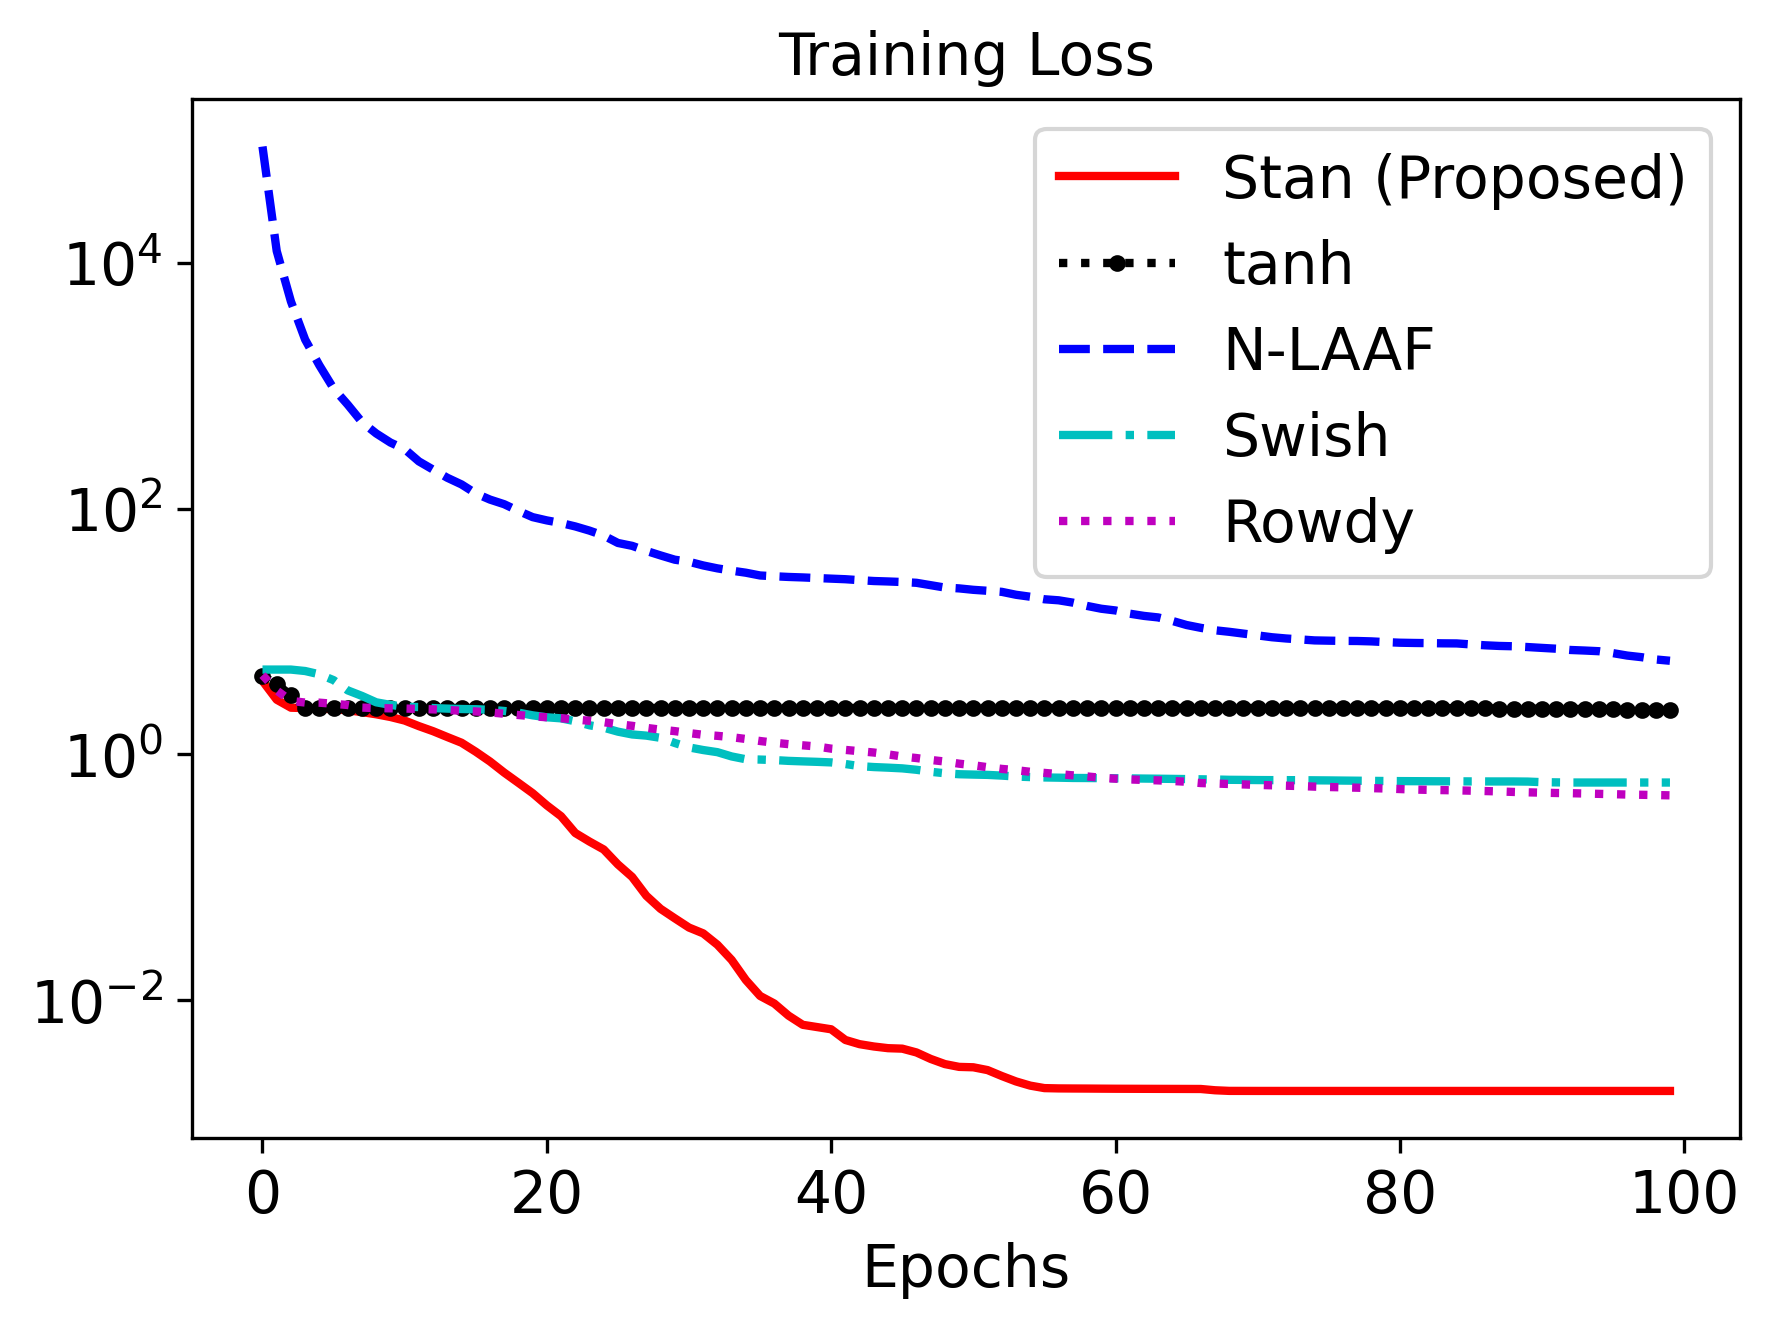

In [15]:
train_loss_stan =  data_stan['train_loss']
train_loss_tanh =  data_tanh['train_loss']
train_loss_atanh =  data_atanh['train_loss']
train_loss_swish =  data_swish['train_loss']
train_loss_rowdy =  data_rowdy['train_loss']


mean_train_loss_stan = np.zeros((num_steps,1))
mean_train_loss_tanh = np.zeros((num_steps,1))
mean_train_loss_atanh = np.zeros((num_steps,1))
mean_train_loss_swish = np.zeros((num_steps,1))
mean_train_loss_rowdy = np.zeros((num_steps,1))


for i in range(10):
    mean_train_loss_stan = mean_train_loss_stan + train_loss_stan[i,:num_steps].reshape(-1,1)
    mean_train_loss_tanh = mean_train_loss_tanh + train_loss_tanh[i,:num_steps].reshape(-1,1)
    mean_train_loss_atanh = mean_train_loss_atanh + train_loss_atanh[i,:num_steps].reshape(-1,1)
    mean_train_loss_swish = mean_train_loss_swish + train_loss_swish[i,:num_steps].reshape(-1,1)
    mean_train_loss_rowdy = mean_train_loss_rowdy + train_loss_rowdy[i,:num_steps].reshape(-1,1)
    
        
mean_train_loss_stan = mean_train_loss_stan/10
mean_train_loss_tanh = mean_train_loss_tanh/10
mean_train_loss_atanh = mean_train_loss_atanh/10
mean_train_loss_swish = mean_train_loss_swish/10
mean_train_loss_rowdy = mean_train_loss_rowdy/10


fig, ax = plt.subplots()
ax.plot(mean_train_loss_stan,'r',linewidth = 2,label = 'Stan (Proposed)')
ax.plot(mean_train_loss_tanh,'k:.',linewidth = 2, label = 'tanh')
ax.plot(mean_train_loss_atanh,'b--',linewidth = 2, label = 'N-LAAF')
ax.plot(mean_train_loss_swish,'c-.',linewidth = 2,label = 'Swish')
ax.plot(mean_train_loss_rowdy,'m:',linewidth = 2, label = 'Rowdy')

#ax.set_fontvariant('normal')

fig.dpi=300
fig.tight_layout()

ax.set_yscale('log')
ax.legend(prop={'size':14})
#ax.set_ylim([0,5])
ax.set_title('Training Loss', fontsize=14)
ax.set_xlabel('Epochs',fontsize=14,alpha = 1)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
 
fig.savefig(prob_name + 'train_loss.eps', format='eps',pad_inches=0, bbox_inches='tight')

In [ ]:
train_loss_atanh.shape

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


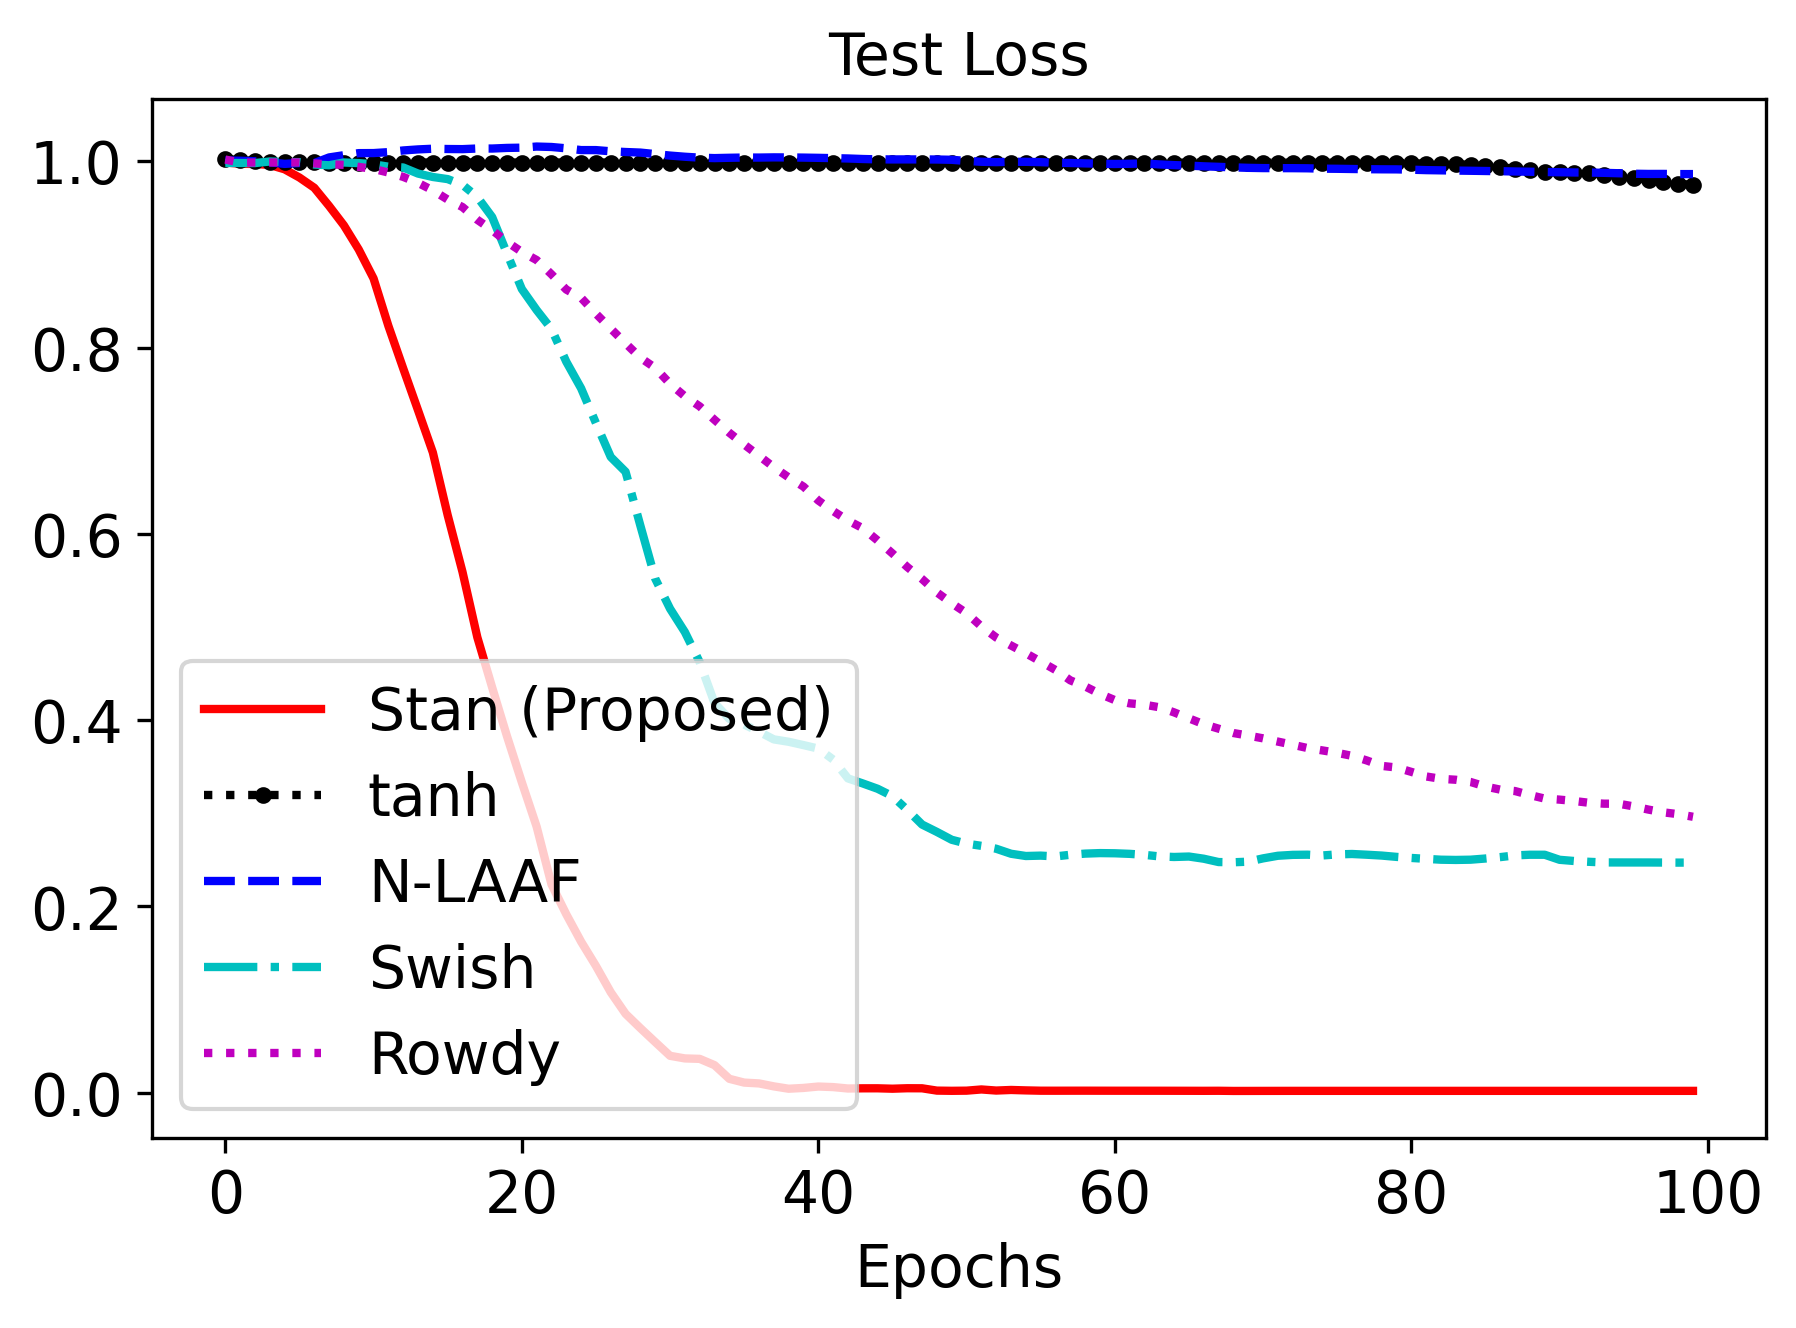

In [16]:
test_loss_stan =  data_stan['test_re_loss']
test_loss_tanh =  data_tanh['test_re_loss']
test_loss_atanh =  data_atanh['test_re_loss']
test_loss_swish =  data_swish['test_re_loss']
test_loss_rowdy =  data_rowdy['test_re_loss']


mean_test_loss_stan = np.zeros((num_steps,1))
mean_test_loss_tanh = np.zeros((num_steps,1))
mean_test_loss_atanh = np.zeros((num_steps,1))
mean_test_loss_swish = np.zeros((num_steps,1))
mean_test_loss_rowdy = np.zeros((num_steps,1))


for i in range(10):
    mean_test_loss_stan = mean_test_loss_stan + test_loss_stan[i,:num_steps].reshape(-1,1)
    mean_test_loss_tanh = mean_test_loss_tanh + test_loss_tanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_atanh = mean_test_loss_atanh + test_loss_atanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_swish = mean_test_loss_swish + test_loss_swish[i,:num_steps].reshape(-1,1)
    mean_test_loss_rowdy = mean_test_loss_rowdy + test_loss_rowdy[i,:num_steps].reshape(-1,1)
    
        
mean_test_loss_stan = mean_test_loss_stan/10
mean_test_loss_tanh = mean_test_loss_tanh/10
mean_test_loss_atanh = mean_test_loss_atanh/10
mean_test_loss_swish = mean_test_loss_swish/10
mean_test_loss_rowdy = mean_test_loss_rowdy/10


fig, ax = plt.subplots()
ax.plot(mean_test_loss_stan,'r',linewidth = 2,label = 'Stan (Proposed)')
ax.plot(mean_test_loss_tanh,'k:.',linewidth = 2, label = 'tanh')
ax.plot(mean_test_loss_atanh,'b--',linewidth = 2, label = 'N-LAAF')
ax.plot(mean_test_loss_swish,'c-.',linewidth = 2,label = 'Swish')
ax.plot(mean_test_loss_rowdy,'m:',linewidth = 2, label = 'Rowdy')

#ax.set_fontvariant('normal')

fig.dpi=300
fig.tight_layout()

#ax.set_yscale('log')
ax.legend(prop={'size':14})
#ax.set_ylim([0,6])
ax.set_title('Test Loss', fontsize=14)
ax.set_xlabel('Epochs',fontsize=14,alpha = 1)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
 
fig.savefig(prob_name+'re.eps', format='eps',pad_inches=0, bbox_inches='tight')

In [17]:
print(mean_test_loss_stan[-1])
print(mean_test_loss_tanh[-1])
print(mean_test_loss_atanh[-1])
print(mean_test_loss_swish[-1])
print(mean_test_loss_rowdy[-1])

[0.00195499]
[0.97466506]
[0.98619517]
[0.24703853]
[0.29622619]


In [18]:
beta_stan =  data_stan['beta']
beta_stan.shape

(10, 100, 50, 9)

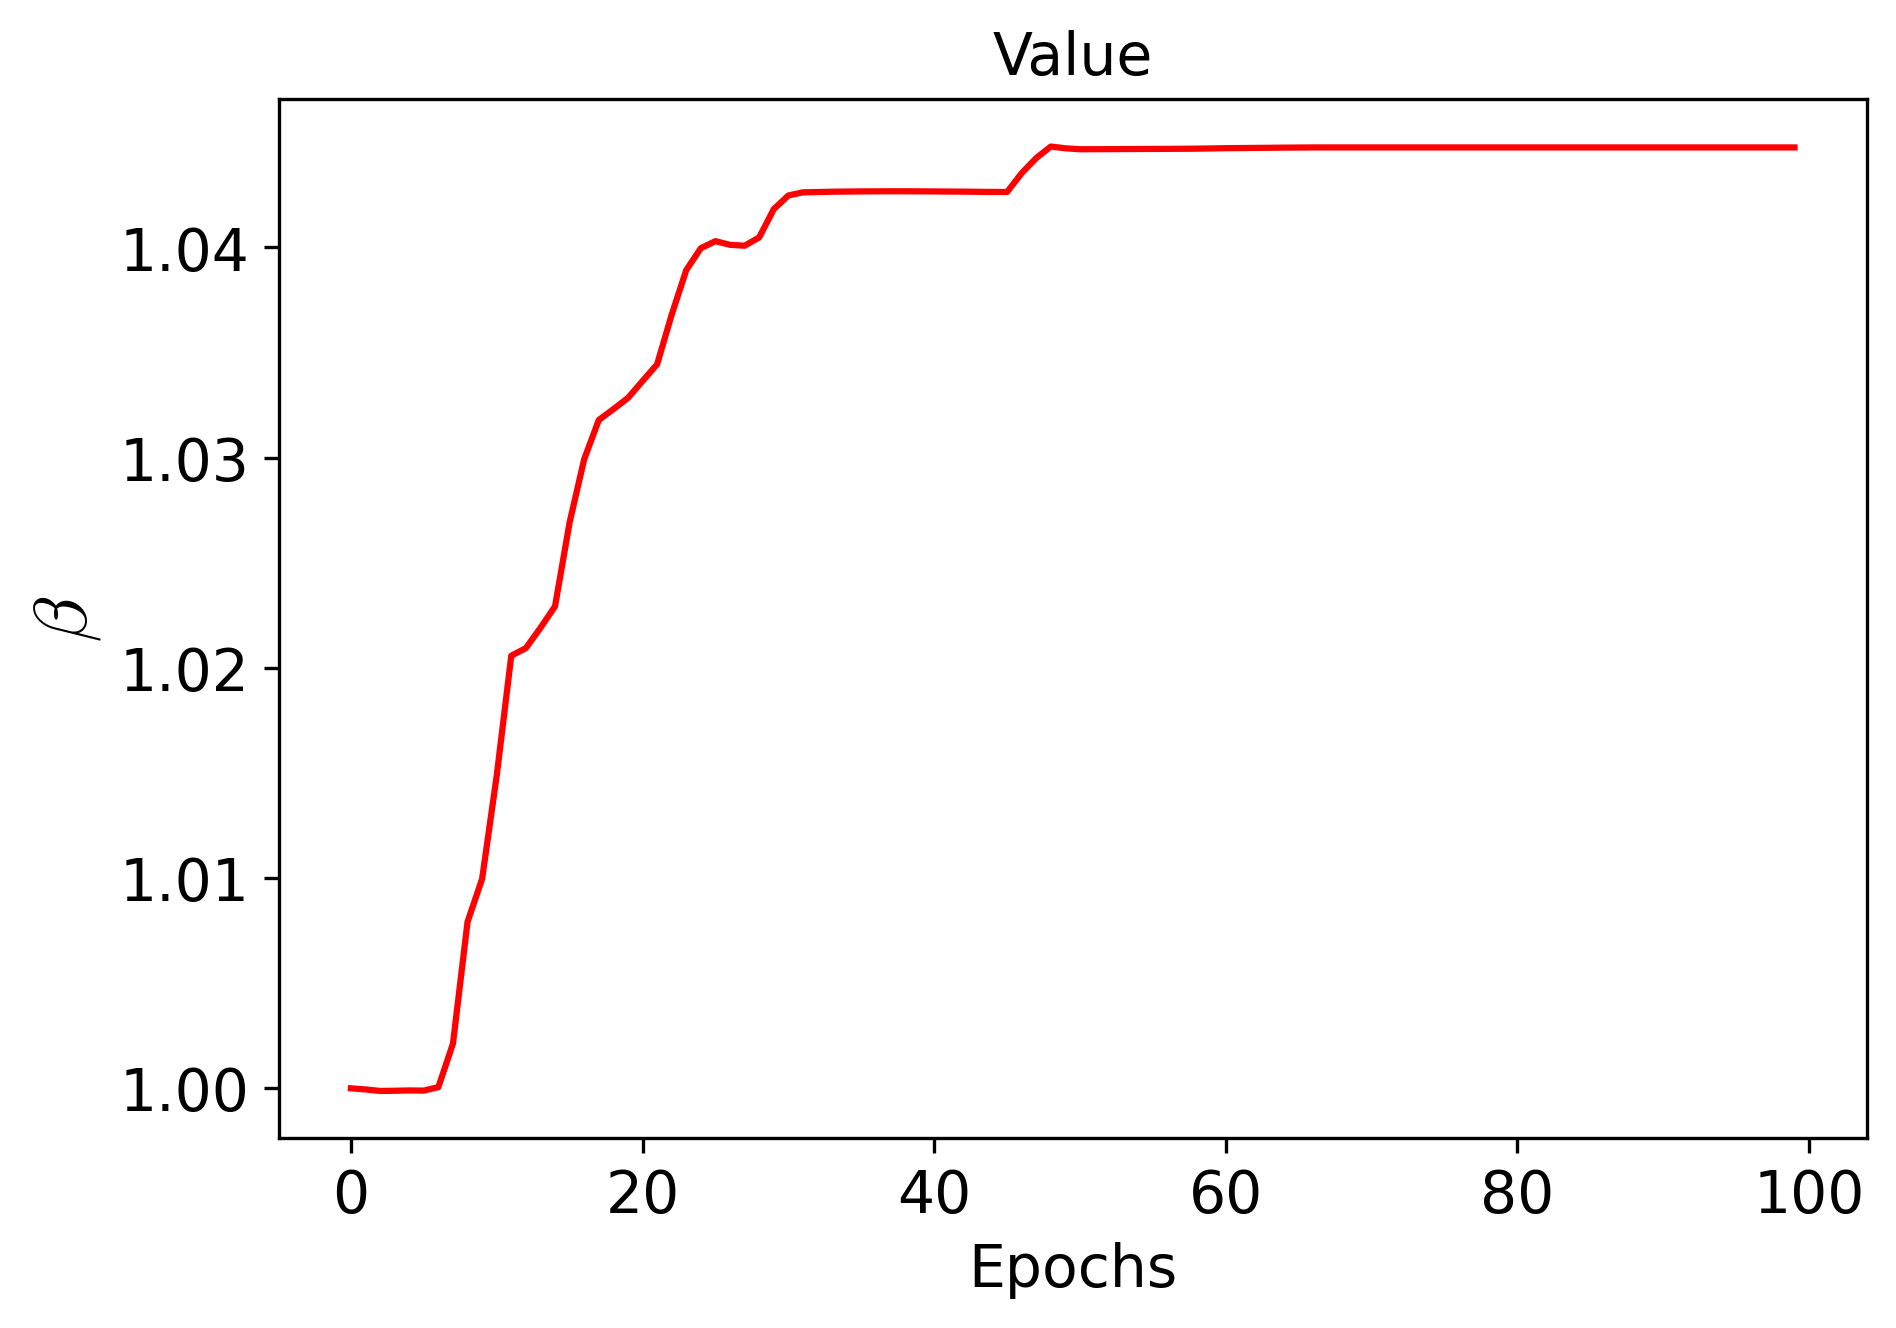

In [19]:
beta_tanhxtanh =  data_stan['beta']

beta_history = beta_tanhxtanh[0,:num_steps,35,7] #For the first repetition

fig, ax = plt.subplots()
ax.plot(beta_history,'r')

fig.dpi=300
fig.tight_layout()

ax.set_title('Value', fontsize=14, math_fontfamily='cm')
ax.set_xlabel('Epochs', fontsize=14, math_fontfamily='cm')
ax.set_ylabel('$\\beta $',fontsize=18, math_fontfamily='cm')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.savefig(prob_name + 'beta_history.eps', format='eps',pad_inches=0, bbox_inches='tight')

In [21]:
class Sequentialmodel_stan(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - 6*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re

class Sequentialmodel_tanh(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 

    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - 6*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re

class Sequentialmodel_atanh(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.alpha = Parameter(torch.ones((50,len(layers)-2)))
        self.alpha.requiresGrad = True
        
        self.n = torch.tensor(3.0)
    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.n*self.alpha[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - 6*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re

class Sequentialmodel_swish(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Sigmoid()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        self.beta = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - 6*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re

class Sequentialmodel_rowdy(nn.Module):
    
    def __init__(self,layers,n_val,rowdy_terms):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
        
        
        self.omega1 = Parameter(torch.ones((len(layers)-2,1))) 
        
        
        self.alpha = Parameter(torch.zeros(rowdy_terms,len(layers)-2))
        self.omega = Parameter(0.1*torch.ones(rowdy_terms,len(layers)-2))
        
        self.n = torch.tensor(n_val)
    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - 6*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re

In [23]:
x = np.linspace(0,2,100).reshape(-1,1)
ysol = true_1D_1(x)

x_test = x.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float()

layers = np.array([1,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

rowdy_terms = 2
n_val = 8.0

model_stan = Sequentialmodel_stan(layers)
model_tanh = Sequentialmodel_tanh(layers)
model_atanh = Sequentialmodel_atanh(layers)
model_swish = Sequentialmodel_swish(layers)
model_rowdy = Sequentialmodel_rowdy(layers,n_val,rowdy_terms)

y_pred_stan = np.zeros((x_test.shape[0],1))
y_pred_tanh = np.zeros((x_test.shape[0],1))
y_pred_atanh = np.zeros((x_test.shape[0],1))
y_pred_swish = np.zeros((x_test.shape[0],1))
y_pred_rowdy = np.zeros((x_test.shape[0],1))

for i in range(10):
    model_stan.load_state_dict(torch.load('./stan/1D_SODE_Stan_'+str(i)+'.pt'))
    y_pred_stan = y_pred_stan + model_stan.test()
    
    model_tanh.load_state_dict(torch.load('./tanh/1D_SODE_tanh_'+str(i)+'.pt'))
    y_pred_tanh = y_pred_tanh + model_tanh.test()
    
    model_atanh.load_state_dict(torch.load('./atanh/1D_SODE_atanh_'+str(i)+'.pt'))
    y_pred_atanh = y_pred_atanh + model_atanh.test()
    
    model_swish.load_state_dict(torch.load('./swish/1D_SODE_swish_'+str(i)+'.pt'))
    y_pred_swish = y_pred_swish + model_swish.test()
    
    model_rowdy.load_state_dict(torch.load('./rowdy/1D_SODE_rowdy_'+str(i)+'.pt'))
    y_pred_rowdy = y_pred_rowdy + model_rowdy.test()
    


y_pred_stan = y_pred_stan/10
y_pred_tanh = y_pred_tanh/10
y_pred_atanh = y_pred_atanh/10
y_pred_swish = y_pred_swish/10
y_pred_rowdy = y_pred_rowdy/10

y_pred = np.hstack((y_pred_stan,y_pred_tanh,y_pred_atanh,y_pred_swish,y_pred_rowdy))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

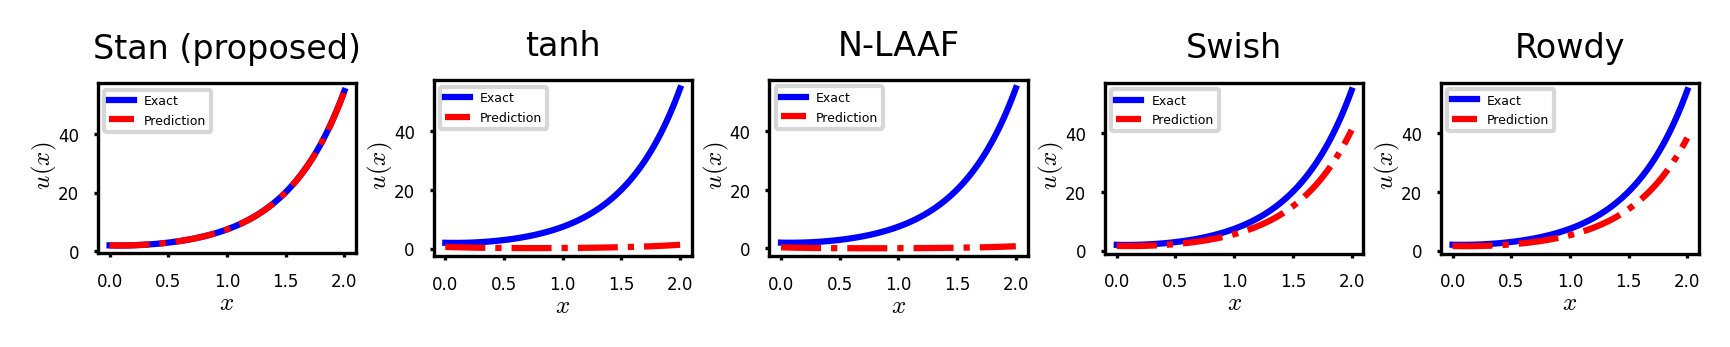

In [24]:
fig, ax = plt.subplots(1,5)

fig.dpi=300
fig.tight_layout()

for i in range(5):
    ax[i].plot(x_test,y_true,'b',linewidth = 1.5,label = 'Exact')
    ax[i].plot(x_test,y_pred[:,i],'r-.',linewidth = 1.5,label = "Prediction")
    
    ax[i].set_xlabel('$x$', fontsize=6, math_fontfamily='cm', labelpad=0.0)
    ax[i].set_ylabel(' $u(x)$',fontsize=6, math_fontfamily='cm', labelpad=0.0)
    
    ax[i].tick_params(axis='x', labelsize=4,length = 1)
    ax[i].tick_params(axis='y', labelsize=4,length = 1)
    
    ax[i].set_aspect(aspect = 1/40)
    
    ax[i].yaxis.set_label_coords(-0.15,0.5)
    
    ax[i].legend(prop={'size':3})

ax[0].set_title('Stan (proposed)',fontsize=8, math_fontfamily='cm')
ax[1].set_title('tanh',fontsize=8, math_fontfamily='cm')
ax[2].set_title('N-LAAF',fontsize=8, math_fontfamily='cm')
ax[3].set_title('Swish',fontsize=8, math_fontfamily='cm')
ax[4].set_title('Rowdy',fontsize=8, math_fontfamily='cm')

    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.savefig(prob_name + 'predictions.eps', format='eps',pad_inches=0, bbox_inches='tight')

In [30]:
#Relative Error
print('Relative Error')
print(mean_test_loss_stan[-1])
print(mean_test_loss_tanh[-1])
print(mean_test_loss_atanh[-1])
print(mean_test_loss_swish[-1])
print(mean_test_loss_rowdy[-1])

Relative Error
[0.00330103]
[367.56810735]
[374.57977588]
[85.01388506]
[69.9404358]


In [31]:
test_loss_stan =  data_stan['test_mse_loss']
test_loss_tanh =  data_tanh['test_mse_loss']
test_loss_atanh =  data_atanh['test_mse_loss']
test_loss_swish =  data_swish['test_mse_loss']
test_loss_rowdy =  data_rowdy['test_mse_loss']


mean_test_loss_stan = np.zeros((num_steps,1))
mean_test_loss_tanh = np.zeros((num_steps,1))
mean_test_loss_atanh = np.zeros((num_steps,1))
mean_test_loss_swish = np.zeros((num_steps,1))
mean_test_loss_rowdy = np.zeros((num_steps,1))


for i in range(10):
    mean_test_loss_stan = mean_test_loss_stan + test_loss_stan[i,:num_steps].reshape(-1,1)
    mean_test_loss_tanh = mean_test_loss_tanh + test_loss_tanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_atanh = mean_test_loss_atanh + test_loss_atanh[i,:num_steps].reshape(-1,1)
    mean_test_loss_swish = mean_test_loss_swish + test_loss_swish[i,:num_steps].reshape(-1,1)
    mean_test_loss_rowdy = mean_test_loss_rowdy + test_loss_rowdy[i,:num_steps].reshape(-1,1)
    
        
mean_test_loss_stan = mean_test_loss_stan/10
mean_test_loss_tanh = mean_test_loss_tanh/10
mean_test_loss_atanh = mean_test_loss_atanh/10
mean_test_loss_swish = mean_test_loss_swish/10
mean_test_loss_rowdy = mean_test_loss_rowdy/10

print('MSE')
print(mean_test_loss_stan[-1])
print(mean_test_loss_tanh[-1])
print(mean_test_loss_atanh[-1])
print(mean_test_loss_swish[-1])
print(mean_test_loss_rowdy[-1])

MSE
[0.00330103]
[367.56810735]
[374.57977588]
[85.01388506]
[69.9404358]


In [27]:
print('Total Time')
print(np.mean(data_stan['Time']))
print(np.mean(data_tanh['Time']))
print(np.mean(data_atanh['Time']))
print(np.mean(data_swish['Time']))
print(np.mean(data_rowdy['Time']))

Total Time
50.690158295631406
18.60474886894226
78.00898306369781
59.11353738307953
78.48745591640473


In [28]:
max_time = np.max(np.vstack((data_stan['Time'],data_tanh['Time'],data_atanh['Time'],data_swish['Time'],data_rowdy['Time'])))

ttime_stan = data_stan['Thresh Time']
ttime_tanh = data_tanh['Thresh Time']
ttime_atanh = data_atanh['Thresh Time']
ttime_swish = data_swish['Thresh Time']
ttime_rowdy = data_rowdy['Thresh Time']

ttime_stan[np.isnan(ttime_stan)] = max_time
ttime_tanh[np.isnan(ttime_tanh)] = max_time
ttime_atanh[np.isnan(ttime_atanh)] = max_time
ttime_swish[np.isnan(ttime_swish)] = max_time
ttime_rowdy[np.isnan(ttime_rowdy)] = max_time

print('Threshold Time')
print(np.mean(ttime_stan))
print(np.mean(ttime_tanh))
print(np.mean(ttime_atanh))
print(np.mean(ttime_swish))
print(np.mean(ttime_rowdy))

Threshold Time
46.323929929733275
128.08077359199524
128.08077359199524
86.6159318447113
121.73673133850097


In [29]:
tep_stan = data_stan['Thresh epoch']
tep_tanh = data_tanh['Thresh epoch']
tep_atanh = data_atanh['Thresh epoch']
tep_swish = data_swish['Thresh epoch']
tep_rowdy = data_rowdy['Thresh epoch']

print('Threshold Epoch')
print(np.mean(tep_stan))
print(np.mean(tep_tanh))
print(np.mean(tep_atanh))
print(np.mean(tep_swish))
print(np.mean(tep_rowdy))

Threshold Epoch
43.8
100.0
100.0
72.5
99.0
